In [1]:
import torch
from torch.nn import functional as F
from diffusers import PNDMScheduler, UNet2DModel
# from diffusers import schedulers
# from PIL import Image

import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms

In [2]:
def show_images(images_tensor:torch.tensor, cmap = "grey"):
    n_dims = images_tensor.dim()
    
    if n_dims in (2,3):
        x_cat = images_tensor

    elif n_dims == 4:
        x_list = [img for img in images_tensor]
        x_cat = torch.cat(x_list,dim=2)
    
    else:
        raise SyntaxError("The dimensions of images_tensor must be between 2 and 4")

    if n_dims != 2:
        if x_cat.shape[0] == 1:
            plt.imshow(x_cat.movedim(0,-1),cmap);
        else:
            plt.imshow(x_cat.movedim(0,-1));
    else:
        plt.imshow(x_cat,cmap);
def show_images_list(images_list:list[torch.Tensor], cmap = "grey") -> None:

    images_tensor = torch.concat(images_list,dim=0)

    # return images_tensor
    # show_images(images_tensor.unsqueeze(1))
    show_images(images_tensor.unsqueeze(1),cmap)


# Cargar el Dataset de Test

In [3]:
preprocess = transforms.Compose([
    transforms.ToTensor(),              #To Torch Tensor
    transforms.Pad(2),                  # Add a padding of 2 pixels
    transforms.Normalize([0.5], [0.5])  # Normalize to (-1,1)
])

def dataset_preprocess(examples):
    images = [preprocess(example) for example in examples["image"]]
    return {"images": images}
dataset = load_dataset("fashion_mnist")

# train_dataset,test_dataset = torch.utils.data.random_split(dataset["train"].with_transform(dataset_preprocess),(0.8,0.2))

val_dataset = torch.utils.data.random_split(dataset["test"].with_transform(dataset_preprocess),(1,))[0]

# train_dataloder = torch.utils.data.DataLoader(
#     train_dataset,
#     shuffle=True,
#     batch_size=256
# )
# test_dataloder = torch.utils.data.DataLoader(
#     test_dataset,
#     shuffle=True,
#     batch_size=256
# )
val_dataloder = torch.utils.data.DataLoader(
    val_dataset,
    shuffle=True,
    batch_size=256
)

# Modelo
Importamos el Modelo del fichero de pesos

In [4]:
base_model = UNet2DModel(
    in_channels=1,  # 1 channels for grey scale
    out_channels=1,
    sample_size=32,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(32, 64, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
        ),

).cuda()

base_model.load_state_dict(torch.load("Base_model_OOD_detection.pth",weights_only=True))
base_model.eval()

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [5]:
scheduler = PNDMScheduler(
    num_train_timesteps=1000, beta_start=0.0015, beta_end=0.0195
)
scheduler.set_timesteps(100)    # Especificamos el nº de pasos de inferencia que usaremos
timesteps_list = scheduler.timesteps.tolist()

# Generación de imágenes

In [6]:
def PNDM_generation_loop(input_img:torch.Tensor, input_timestep : int, model: UNet2DModel, scheduler : PNDMScheduler):

    if input_img.dim() != 4:     # Control de Errores
        raise SyntaxError("Error de Dimensiones. El Tensor de entrada dbe tener 4 dimensions, siendo la primera la dimensión de lote")
    
    noisy_x = input_img

    if input_timestep < 0 or input_timestep > 1000: # Control de Errores
        raise SyntaxError("El timestep debe estar entre 0 y 1000")
    
    idx = torch.where(scheduler.timesteps == input_timestep)[0][0]  # Buscamos el indice del timestep aleatorio en la lista del scheduler

    for t in scheduler.timesteps[idx:]:     # Iteramos sobre la lista del scheduler. Cada elemento es uno de los timesteps de la cadena

        with torch.inference_mode():        # Realizamos un paso de la iteración
            noise_pred = model(noisy_x, t,return_dict=False)[0]

        scheduler_output = scheduler.step(noise_pred, t, noisy_x)   # Paso del scheduler

        noisy_x = scheduler_output.prev_sample                      # Realimentamos el bucle
    
    return(scheduler_output.prev_sample)  # Devolvemos el resultado.

In [7]:
img = next(iter(val_dataloder))["images"].cuda()    # Elegimos un lote de imágenes
print(len(img))

256


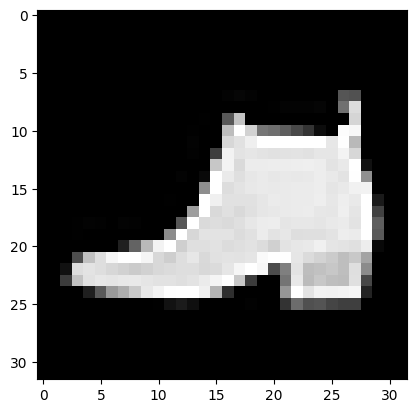

In [8]:
show_images(img[0].cpu())   # Mostramos una de las imágenes

In [9]:
noise = torch.randn_like(img)   # Generamos el Ruido
noise.shape

torch.Size([256, 1, 32, 32])

In [17]:
rand_timestep_idx = torch.randint(0,len(timesteps_list),(1,))               # Elegimos el timestep aleatorio de la lista del Scheduler
rand_timestep = timesteps_list[rand_timestep_idx]

rand_timestep_tensor = torch.ones((val_dataloder.batch_size,),dtype=int)*rand_timestep
rand_timestep_tensor[0]

tensor(180)

In [18]:
noisy_img = scheduler.add_noise(img,noise,rand_timestep_tensor)         # Añadimos Ruido a las imágenes

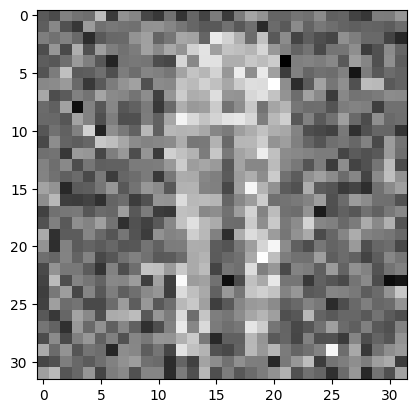

In [19]:
show_images(noisy_img[5].cpu())     # Mostramos una imagen con ruido

In [20]:
regeneration = PNDM_generation_loop(noisy_img,rand_timestep,base_model,scheduler)       # Realizamos la Restauración

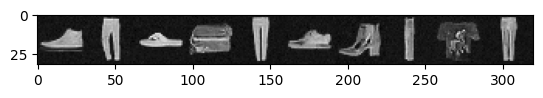

In [21]:
show_images(regeneration[10:20].cpu())  # Mostramos las imágenes restauradas

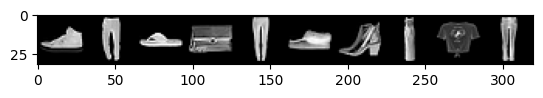

In [15]:
show_images(img[10:20].cpu())   # Mostramos las imágenes originales